<a href="https://colab.research.google.com/github/eshmaneva/DS-Practical/blob/main/T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-ldky106b
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-ldky106b
  Running command git submodule update --init --recursive -q
  From https://github.com/PyTorchLightning/lightning-tutorials
   * branch            290fb466de1fcc2ac6025f74b56906592911e856 -> FETCH_HEAD
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [7]:
!pip install nlp
from nlp import load_metric

In [8]:
!pip install transformers==4.18.0
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 84.8 MB/s 
     |████████████████████████████████| 895 kB 75.7 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 


In [10]:
'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
'''
#Vladana run
#dataset=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Reviews.csv", engine="python", error_bad_lines=False)

dataset=pd.read_csv("/content/drive/MyDrive/DS Practical/Reviews.csv", engine="python", error_bad_lines=False)
dataset.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Score', 'Time'],axis=1,inplace=True)
print("Before",len(dataset))
dataset = dataset.dropna()
print("Data size:",len(dataset))
dataset.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Before 568454
Data size: 568427


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


# **Using WikiHow dataset (as in initial repository)**

In [16]:
from nlp import list_datasets
datasets_list = list_datasets()
print(', '.join(dataset.id for dataset in datasets_list))

acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, americas_nli, ami, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, ascent_kb, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, babi_qa, banking77, bbaw_egyptian, bbc_hindi_nli, bc2gm_corpus, beans, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, biosses, blbooks, blbooksgenre, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bnl_newspapers, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, casino, catalonia_independence, cats_vs_dogs, cawac, cbt, cc100, cc_news, ccaligned_multilingual, cdsc, cdt

In [20]:
from nlp import load_dataset
dataset = load_dataset('wikihow', 'all', data_dir='/content/drive/MyDrive/DS Practical/')

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikihow downloaded and prepared to /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683. Subsequent calls will reuse this data.


In [21]:
print(dataset.keys())
print("Size of train dataset: ", dataset['train'].shape)
print("Size of Validation dataset: ", dataset['validation'].shape)
print("Size of ca test dataset: ", dataset['test'].shape)

dict_keys(['train', 'validation', 'test'])
Size of train dataset:  (157252, 3)
Size of Validation dataset:  (5599, 3)
Size of ca test dataset:  (5577, 3)


In [22]:
print(dataset['train'][0].keys())

dict_keys(['headline', 'text', 'title'])


In [23]:
print(" Example of text: ", dataset['train'][2]['text'])

 Example of text:  It is possible to become a VFX artist without a college degree, but the path is often easier with one. VFX artists usually major in fine arts, computer graphics, or animation. Choose a college with a reputation for strength in these areas and a reputation for good job placement for graduates. The availability of internships is another factor to consider.Out of the jobs advertised for VFX artists, a majority at any given time specify a bachelor’s degree as a minimum requirement for applicants.;
, Some studios offer short-term programs for people who want to learn more about VFX artistry without pursuing a college degree. Enrolling in these programs can be expensive as financial aid isn’t always offered, but they usually have the most cutting edge technology for you to learn from., Although you may create some hand sketches, the majority of your work will be completed on the computer using the most up-to-date programs. Stay informed about the newest software advances b

In [24]:
tiny_dataset = dataset['train'].select(list(range(0, 100)))
text_len = []
summary_len=[]

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['text']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example['headline']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

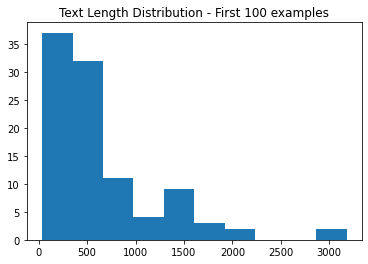

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(text_len)
plt.title('Text Length Distribution - First 100 examples')
plt.show()

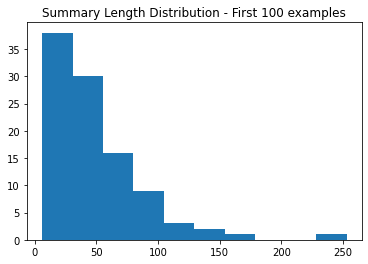

In [27]:
plt.hist(summary_len)
plt.title('Summary Length Distribution - First 100 examples')
plt.show()

In [28]:
print("Average Length of text: ", sum(text_len)/len(text_len))
print("Average Length of Summary: ", sum(summary_len)/len(summary_len))

Average Length of text:  662.69
Average Length of Summary:  48.8


In [29]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [30]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.proc_rank <= 0
    
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_metric.add_batch(preds, target)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)
#         base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [31]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

In [32]:
class wikihow(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('wikihow', 'all', data_dir='data/', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['text']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['headline'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

In [34]:
! pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.9 MB/s 


In [39]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
dataset = wikihow(tokenizer, 'validation', None, 512, 150, True)
len(dataset)

TypeError: ignored

In [40]:
data = dataset[50]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))

KeyError: ignored

In [41]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_input_length=512,
    max_output_length=150,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=8,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.05, 
    n_val=1000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [42]:
args_dict.update({'output_dir': 't5_wikihow', 'num_train_epochs':2,
                 'train_batch_size': 4, 'eval_batch_size': 4})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'output_dir': 't5_wikihow', 'model_name_or_path': 't5-small', 'tokenizer_name_or_path': 't5-small', 'max_input_length': 512, 'max_output_length': 150, 'freeze_encoder': False, 'freeze_embeds': False, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 4, 'eval_batch_size': 4, 'num_train_epochs': 2, 'gradient_accumulation_steps': 8, 'n_gpu': 1, 'resume_from_checkpoint': None, 'val_check_interval': 0.05, 'n_val': 1000, 'n_train': -1, 'n_test': -1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [65]:
## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="/content/drive/MyDrive/DS Practical/",
    #prefix="checkpoint",
    monitor="val_loss",
    mode="min",
    save_top_k=3)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    val_check_interval=args.val_check_interval,
    #logger=wandb_logger,
    callbacks=[LoggingCallback()],
)

In [66]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return wikihow(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

In [63]:
model = T5FineTuner(args)

AttributeError: ignored

In [67]:
trainer = pl.Trainer(**train_params)

MisconfigurationException: ignored

In [ ]:
trainer.fit(model)

In [ ]:
import textwrap
from tqdm.auto import tqdm

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = wikihow(tokenizer, 'test', None, 512, 150, False)

In [ ]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

In [ ]:
model.to('cuda')
outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
for i in range(32):
    lines = textwrap.wrap("WikiHow Text:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual Summary: %s" % targets[i])
    print("\nPredicted Summary: %s" % dec[i])
    print("=====================================================================\n")

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("deep-learning-analytics/wikihow-t5-small")

model = AutoModelWithLMHead.from_pretrained("deep-learning-analytics/wikihow-t5-small")

In [ ]:
## Move to CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
text = """"
Lack of fluids can lead to dry mouth, which is a leading cause of bad breath. Water
can also dilute any chemicals in your mouth or gut that are causing bad breath., Studies show that
eating 6 ounces of yogurt a day reduces the level of odor-causing compounds in the mouth. In
particular, look for yogurt containing the active bacteria Streptococcus thermophilus or
Lactobacillus bulgaricus., The abrasive nature of fibrous fruits and vegetables helps to clean
teeth, while the vitamins, antioxidants, and acids they contain improve dental health.Foods that can
be particularly helpful include:Apples — Apples contain vitamin C, which is necessary for health
gums, as well as malic acid, which helps to whiten teeth.Carrots — Carrots are rich in vitamin A,
which strengthens tooth enamel.Celery — Chewing celery produces a lot of saliva, which helps to
neutralize bacteria that cause bad breath.Pineapples — Pineapples contain bromelain, an enzyme that
cleans the mouth., These teas have been shown to kill the bacteria that cause bad breath and
plaque., An upset stomach can lead to burping, which contributes to bad breath. Don’t eat foods that
upset your stomach, or if you do, use antacids. If you are lactose intolerant, try lactase tablets.,
They can all cause bad breath. If you do eat them, bring sugar-free gum or a toothbrush and
toothpaste to freshen your mouth afterwards., Diets low in carbohydrates lead to ketosis — a state
in which the body burns primarily fat instead of carbohydrates for energy. This may be good for your
waistline, but it also produces chemicals called ketones, which contribute to bad breath.To stop the
problem, you must change your diet. Or, you can combat the smell in one of these ways:Drink lots of
water to dilute the ketones.Chew sugarless gum or suck on sugarless mints.Chew mint leaves.
"""

In [ ]:
preprocess_text = text.strip().replace("\n","")
tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)

In [ ]:
summary_ids = model.generate(
            tokenized_text,
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

In [ ]:
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)